# Example 5

The aim of this notebook is to go forward in the analysis performed by Audrey BROUILLET (IRD) : we perform simulations for millet in Niger from years 1981-2021 and compute different indices, such as beginning of season, end of season, season length, water-stress related indices, and atteinable yield.

## Imports

In [14]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

 ## Analysis parameters

In [16]:
# weather and rainfall data path
rainfall_data_paths = {
                        "CHIRPS" : "/mnt/d/climate_database/CHIRPS_v2.0_Africa_niger/", # 1981-2022
                        "TAMSAT" : "/mnt/d/climate_database/TAMSAT_v3.1_niger_rfe_filled_1983_2021_DL20230614/" # 1983-2021
                      }
climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/" # 1981-2021

# parameter files
file_paramVariete = "millet_variety_exemple5.yaml"
file_paramITK = "millet_exemple5.yaml"
file_paramTypeSol = "exemple5.yaml"

# file_paramVariete = "millet_variety.yaml"
# file_paramITK = "millet_niger_2017.yaml"
# file_paramTypeSol = "USA_iowa_V42.yaml"

# parameters for time series analysis
year_start = 1983
year_end = 2022
duration = 200 # we load all days of the year for this analysis
dataset = "CHIRPS"

In [17]:
# we start by loading the estimated sowing dates, previously produced for CHIRPS and TAMSAT

# listing the result files
# path = "./exemple_3_sowing_date_timeseries/"+dataset+"/"
# files = os.listdir(path)
# files.sort()

# years = [int(file.split(".")[0]) for file in files]

# Defining functions

In [18]:
def save_figure(variable, dataset, year):
        if not os.path.exists("./exemple_5/{}/".format(variable)):
                os.makedirs("./exemple_5/{}/".format(variable), exist_ok=True)

        data[variable].astype('float32').rio.to_raster("./exemple_5/{}/{}_{}_{}.tif".format(variable, variable, dataset, year))

def calc_anomalies(variable, data, zscore_thresh):
        data[variable+"_in_season"] = xr.where(data["time"] >= data["date_begin_season"],
                xr.where(data["time"] <= data["date_end_season"],
                        data[variable],
                        np.nan),
                np.nan)

        data[variable+"_in_season_mean"] = data[variable+"_in_season"].mean(dim="time")
        data[variable+"_in_season_std"] = data[variable+"_in_season"].std(dim="time")
        data[variable+"_in_season_zscore"] = (data[variable+"_in_season"] - data[variable+"_in_season_mean"]) / data[variable+"_in_season_std"]
        #data[variable+"_in_season_zscore"].plot()
        data[variable+"_in_season_anomaly_pos"] = xr.where(data[variable+"_in_season_zscore"] > zscore_thresh, 1, 0)
        #data[variable+"_in_season_anomaly_pos"].sum(dim="time").plot()
        #plt.show()
        data[variable+"_in_season_anomaly_neg"] = xr.where(data[variable+"_in_season_zscore"] < -zscore_thresh, 1, 0)
        #data[variable+"_in_season_anomaly_neg"].sum(dim="time").plot()
        #plt.show()

        return data


# performing the analysis by running the model

In [19]:
# for year_id in tqdm(range(year_start - 1981,year_end-1981)):
for year in range(year_start,year_end):
    #try:
        # year = years[year_id]

        print("year",str(year))
        # defining date of simulation start and simulation length in days
        date_start = datetime.date(year,1,1)

        # retrieving the grid size from the rainfall data (this method will be deprecated in the future)
        rainfall_data_path = rainfall_data_paths[dataset]
        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)

        ## preparing the base dataset
        # initialize empty xarray dataset to load base data
        base_data = xr.Dataset()

        # load rainfall and weather data
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

        # load soil data using the iSDA method (uses more recent maps)
        base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

        # compute the day lengthµ
        base_data = calc_day_length_raster_fast(base_data, date_start, duration)

        ## prepating simulation dataset
        # load variety, cropping system and soil parameters
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)
        paramITK["DateSemis"] = datetime.date(year,4,1)
        print(paramITK["DateSemis"])
        
        # creating simulation xarray dataset by copying the base data
        data = base_data.copy()

        del base_data

        print(paramITK["DateSemis"])

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        print(paramITK["DateSemis"])
        data = initialize_default_irrigation(data)
        print(paramITK["DateSemis"])
        data = calculate_once_daily_thermal_time(data, paramVariete)
        print(paramITK["DateSemis"])

        ## running the model
        data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)
        print(paramITK["DateSemis"])

        




        """

        verbose=False

        # calculating date of end of season
        argmax = ((data["numPhase"]==7) & (data["changePhase"]==1)).argmax(axis=0)
        data["date_end_season"] = xr.where(argmax==0, np.nan, argmax)
        if verbose :
                data["date_end_season"].plot()
                plt.title("date_end_season")
                plt.show()
        # plt.hist(data["date_end_season"].values.flatten())
        # plt.show()

        # saving end of season
        variable = "date_end_season"
        save_figure(variable, dataset, year)


        # calculating beginning of season
        argmax = ((data["numPhase"]==1) & (data["changePhase"]==1)).argmax(axis=0)
        data["date_begin_season"] = xr.where(argmax==0, np.nan, argmax)
        if verbose :
                data["date_begin_season"].plot()
                plt.title("date_begin_season")
                plt.show()
        # plt.hist(data["date_begin_season"].values.flatten())
        # plt.show()

        # saving beginning of season
        variable = "date_begin_season"
        save_figure(variable, dataset, year)


        # calculating duration of season
        data["season_length"] = data["date_end_season"] - data["date_begin_season"]
        if verbose :
                data["season_length"].plot()
                plt.title("season_length")
                plt.show()
        # plt.hist(data["season_length"].values.flatten())
        # plt.show()

        # saving duration of season
        variable = "season_length"
        save_figure(variable, dataset, year)





        # calculating cstr related variables
        variable = "cstr"
        zscore_thresh = 2.5
        data = calc_anomalies(variable, data, zscore_thresh)

        # calculating number of days in season under cstr thres
        cstr_thres=0.5
        data["days_under_cstr_thres"] = xr.where(((data["cstr_in_season"]<cstr_thres).sum(axis=0))==0,np.nan,(data["cstr_in_season"]<cstr_thres).sum(axis=0))
        if verbose :
                data["days_under_cstr_thres"].plot()
                plt.title("days_under_cstr_thres")
                plt.show()

        # saving number of days in season under cstr thres
        variable = "days_under_cstr_thres"
        save_figure(variable, dataset, year)


        # calculating in season mean value for cstr
        # (already calculated via calc_anomalies)
        if verbose :
                data["cstr_in_season_mean"].plot()
                plt.title("cstr_in_season_mean")
                plt.show()

        # saving in season mean value for cstr
        variable = "cstr_in_season_mean"
        save_figure(variable, dataset, year)


        # calculating yield
        data["yield"] = xr.where(data["rdt"][-1,:,:]==0,np.nan,data["rdt"][-1,:,:])
        if verbose :
                data["yield"].plot()
                plt.title("yield")
                plt.show()

        # saving yield
        variable = "yield"
        save_figure(variable, dataset, year)

        """




        

        # del data
        # del base_data
    #except:
    #    print("issue with year",str(year))
    
    


year 1983


100%|██████████| 5/5 [00:50<00:00, 10.00s/it]


1983-04-01
1983-04-01
1983-04-01
1983-04-01
1983-04-01


100%|██████████| 200/200 [03:57<00:00,  1.19s/it]


1983-04-01
year 1984


100%|██████████| 5/5 [00:50<00:00, 10.03s/it]


1984-04-01
1984-04-01
1984-04-01
1984-04-01
1984-04-01


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


1984-04-01
year 1985


100%|██████████| 5/5 [00:40<00:00,  8.18s/it]


1985-04-01
1985-04-01
1985-04-01
1985-04-01
1985-04-01


 78%|███████▊  | 155/200 [02:29<00:43,  1.04it/s]


KeyboardInterrupt: 

In [ ]:
xxx

# Plotting results

In [12]:
def make_fig(variable, dataset):
    #variable = "yield"
    path = "./exemple_5/"+variable+"/"

    # list all files in path
    files = os.listdir(path)
    files = [file for file in files if dataset in file]
    files.sort()

    # load all files in a xarray dataarray, make sure filenames are taken in order
    data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")

    # give time axis the correct values
    data["time"] = [int(file.split(".")[0].split("_")[-1]) for file in files if "CHIRPS" in file]

    # increase plot size
    plt.rcParams['figure.figsize'] = [20, 10]

    data.mean(dim=["x"]).T.plot()
    #rename y axis
    plt.ylabel("Latitude (°)")
    plt.title(variable)
    plt.show()

/tmp/ipykernel_7018/3773390971.py:11: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")


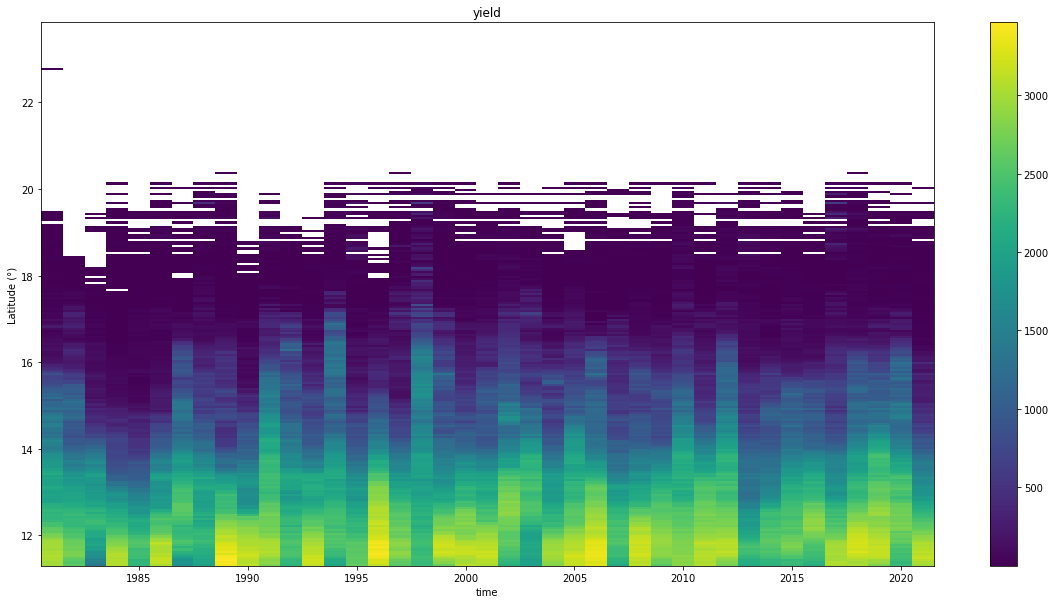

In [22]:
make_fig("yield", "CHIRPS")

/tmp/ipykernel_13812/3669233552.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")


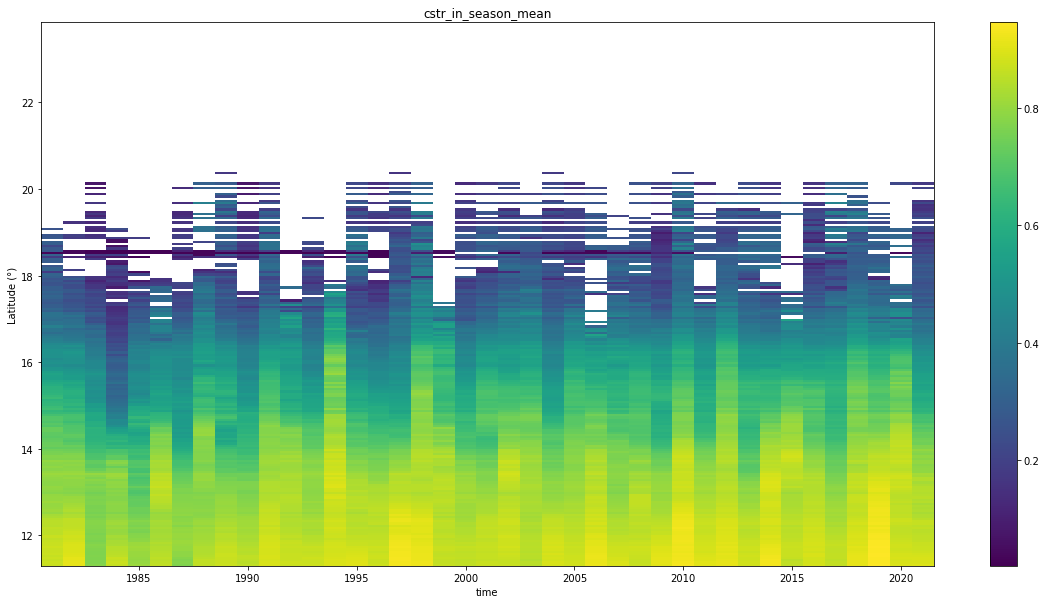

In [ ]:
make_fig("cstr_in_season_mean")

/tmp/ipykernel_7018/3773390971.py:11: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")


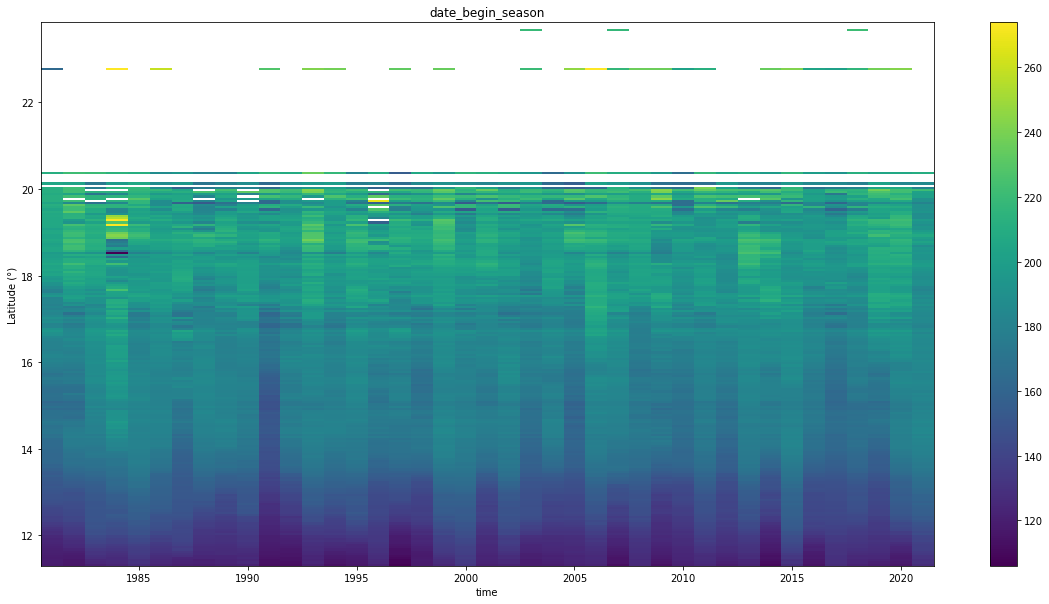

In [13]:
make_fig("date_begin_season", "CHIRPS")

/tmp/ipykernel_7018/3773390971.py:11: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")


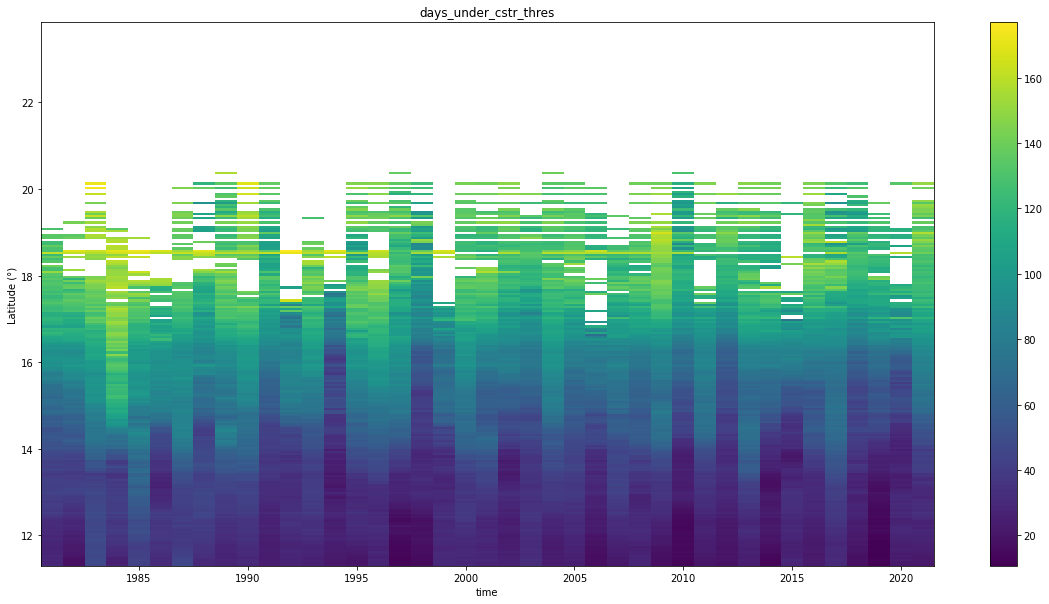

In [23]:
make_fig("days_under_cstr_thres", "CHIRPS")

/tmp/ipykernel_13812/3669233552.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")


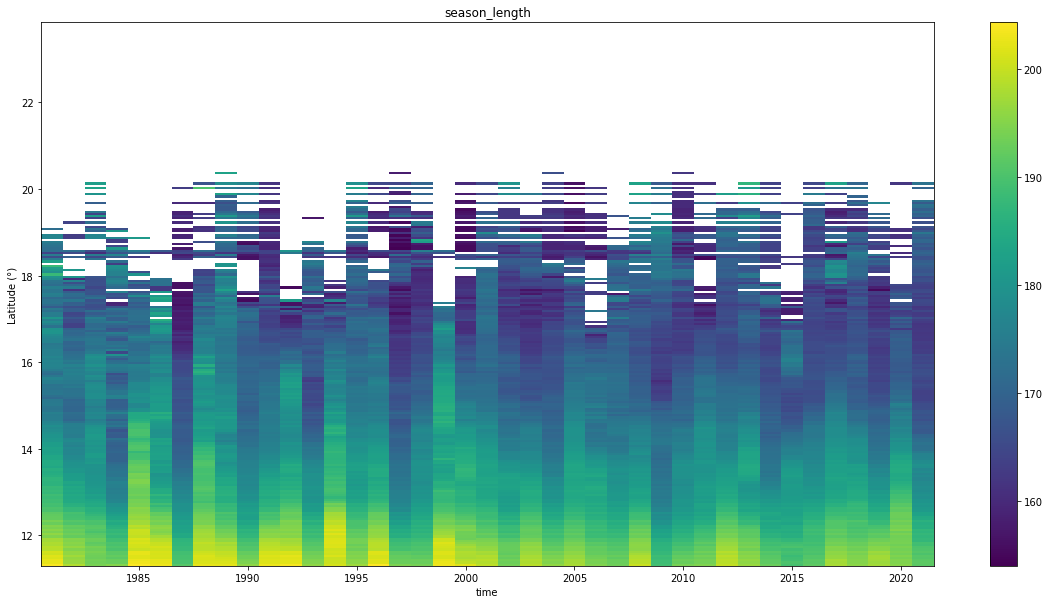

In [ ]:
make_fig("season_length")

/tmp/ipykernel_13812/3669233552.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.concat([xr.open_rasterio(path+file) for file in files], dim="time")


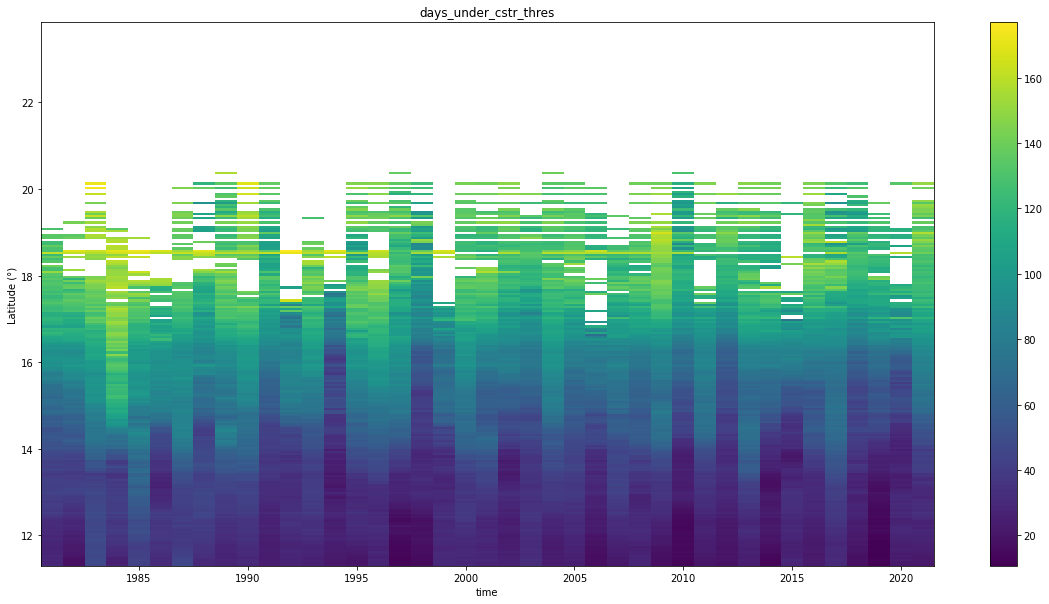

In [ ]:
make_fig("days_under_cstr_thres")
